### Importing Libraries


In [37]:
# Import basic libraries
import numpy as np  # For working with arrays and numerical data
import pandas as pd  # For handling tabular data

# For loading and processing images
from PIL import Image

# For plotting images and graphs
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch libraries for datasets and data loading
from torch.utils.data import Dataset, DataLoader

# PyTorch image transformations (resize, normalize, etc.)
import torchvision.transforms as transforms

# PyTorch core and neural network modules
import torch
import torch.nn as nn
import torch.optim as optim

# Pretrained ResNet models
from torchvision.models import resnet18, resnet34, resnet50

# For splitting data into train and test sets and for confusion matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# For evaluating model performance
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# For balancing classes if needed
from sklearn.utils import resample

# For file handling
import os
import glob  # For finding files with specific patterns

# For handling date and time
from datetime import datetime

In [ ]:
# Load training labels from CSV file
train = pd.read_csv(
    "src/task2/train_labels.csv")

# Load test image IDs from CSV file
test = pd.read_csv(
    "src/task2/test_ids.csv")

# Define directory paths for train and test images
train_dir = "src/task2/train"
test_dir = "src/task2/test"

# Print the first few rows of the training and test dataframes to check the contents
print(train.head())
print(test.head())

In [39]:
# Load training labels from CSV file
train = pd.read_csv(
    "/kaggle/input/soil-classification-part-2/soil_competition-2025/train_labels.csv")

# Load test image IDs from CSV file
test = pd.read_csv(
    "/kaggle/input/soil-classification-part-2/soil_competition-2025/test_ids.csv")

# Define directory paths for train and test images
train_dir = "/kaggle/input/soil-classification-part-2/soil_competition-2025/train"
test_dir = "/kaggle/input/soil-classification-part-2/soil_competition-2025/test"

# Print the first few rows of the training and test dataframes to check the contents
print(train.head())
print(test.head())

           image_id  label
0  img_ed005410.jpg      1
1  img_0c5ecd2a.jpg      1
2  img_ed713bb5.jpg      1
3  img_12c58874.jpg      1
4  img_eff357af.jpg      1
                               image_id
0  6595f1266325552489c7d1635fafb88f.jpg
1  4b614841803d5448b59e2c6ca74ea664.jpg
2  ca30e008692a50638b43d944f46245c8.jpg
3  6a9046a219425f7599729be627df1c1a.jpg
4  97c1e0276d2d5c2f88dddbc87357611e.jpg


### Preprocessing the Image Data and Loading Train/Test Data


In [40]:
# Create a dictionary mapping image_id to label
label_dict = dict(zip(train['image_id'], train['label']))

# List to store image data and labels
train_data_list = []

# Loop through each image ID in the training data
for image_id in train['image_id']:
    # Create full path to the image file
    image_path = os.path.join(train_dir, image_id)

    # Check if the image file exists
    if os.path.exists(image_path):
        # Open the image and convert it to RGB format
        image = Image.open(image_path).convert("RGB")

        # Get the corresponding label label
        label = label_dict[image_id]

        # Add image ID, image data, and label to the list
        train_data_list.append({
            'image_id': image_id,
            'image_data': image,
            'label': label
        })

# Convert the list to a DataFrame for easier handling
train_data = pd.DataFrame(train_data_list)

# Display the first few rows of the processed training data
print(train_data.head())

           image_id                                         image_data  label
0  img_ed005410.jpg  <PIL.Image.Image image mode=RGB size=728x728 a...      1
1  img_0c5ecd2a.jpg  <PIL.Image.Image image mode=RGB size=1160x522 ...      1
2  img_ed713bb5.jpg  <PIL.Image.Image image mode=RGB size=1160x522 ...      1
3  img_12c58874.jpg  <PIL.Image.Image image mode=RGB size=1160x522 ...      1
4  img_eff357af.jpg  <PIL.Image.Image image mode=RGB size=1160x522 ...      1


In [41]:
# Initialize an empty DataFrame for test data
test_data = pd.DataFrame()

# Dictionary to store test images by their filenames
test_data_dict = {}

# Walk through the test directory to find image files
for dirname, _, filenames in os.walk(test_dir):
    for filename in filenames:
        # Build the full path to the image file
        image_path = os.path.join(dirname, filename)

        # Open the image and convert it to RGB format
        image = Image.open(image_path).convert("RGB")

        # Store the image in the dictionary with filename as the key
        test_data_dict[filename] = image

# Create a list to store matched test images with their IDs
test_data_list = []

# Loop through the test image IDs from the CSV file
for image_id in test['image_id']:
    # If the image exists in the dictionary, add it to the list
    if image_id in test_data_dict:
        test_data_list.append({
            'image_id': image_id,
            'image_data': test_data_dict[image_id]
        })

# Convert the list into a DataFrame
test_data = pd.DataFrame(test_data_list)

# Show the first few rows of the test data
print(test_data.head())

                               image_id  \
0  6595f1266325552489c7d1635fafb88f.jpg   
1  4b614841803d5448b59e2c6ca74ea664.jpg   
2  ca30e008692a50638b43d944f46245c8.jpg   
3  6a9046a219425f7599729be627df1c1a.jpg   
4  97c1e0276d2d5c2f88dddbc87357611e.jpg   

                                          image_data  
0  <PIL.Image.Image image mode=RGB size=319x158 a...  
1  <PIL.Image.Image image mode=RGB size=1500x1125...  
2  <PIL.Image.Image image mode=RGB size=462x280 a...  
3  <PIL.Image.Image image mode=RGB size=1500x1101...  
4  <PIL.Image.Image image mode=RGB size=100x100 a...  


### Converting labels into Integers


In [42]:
# Get the unique label labels from the training data
unique_labels = [0, 1]

In [43]:
# Create a mapping from label (string) to a unique integer label
label_mapping = {soil: idx for idx, soil in enumerate(unique_labels)}

# Print the mapping to see which label corresponds to which label
print(label_mapping)

# Replace the label strings in the training data with their corresponding integer labels
train_data['label'] = train_data['label'].map(label_mapping)

{0: 0, 1: 1}


### Visualizing the train data


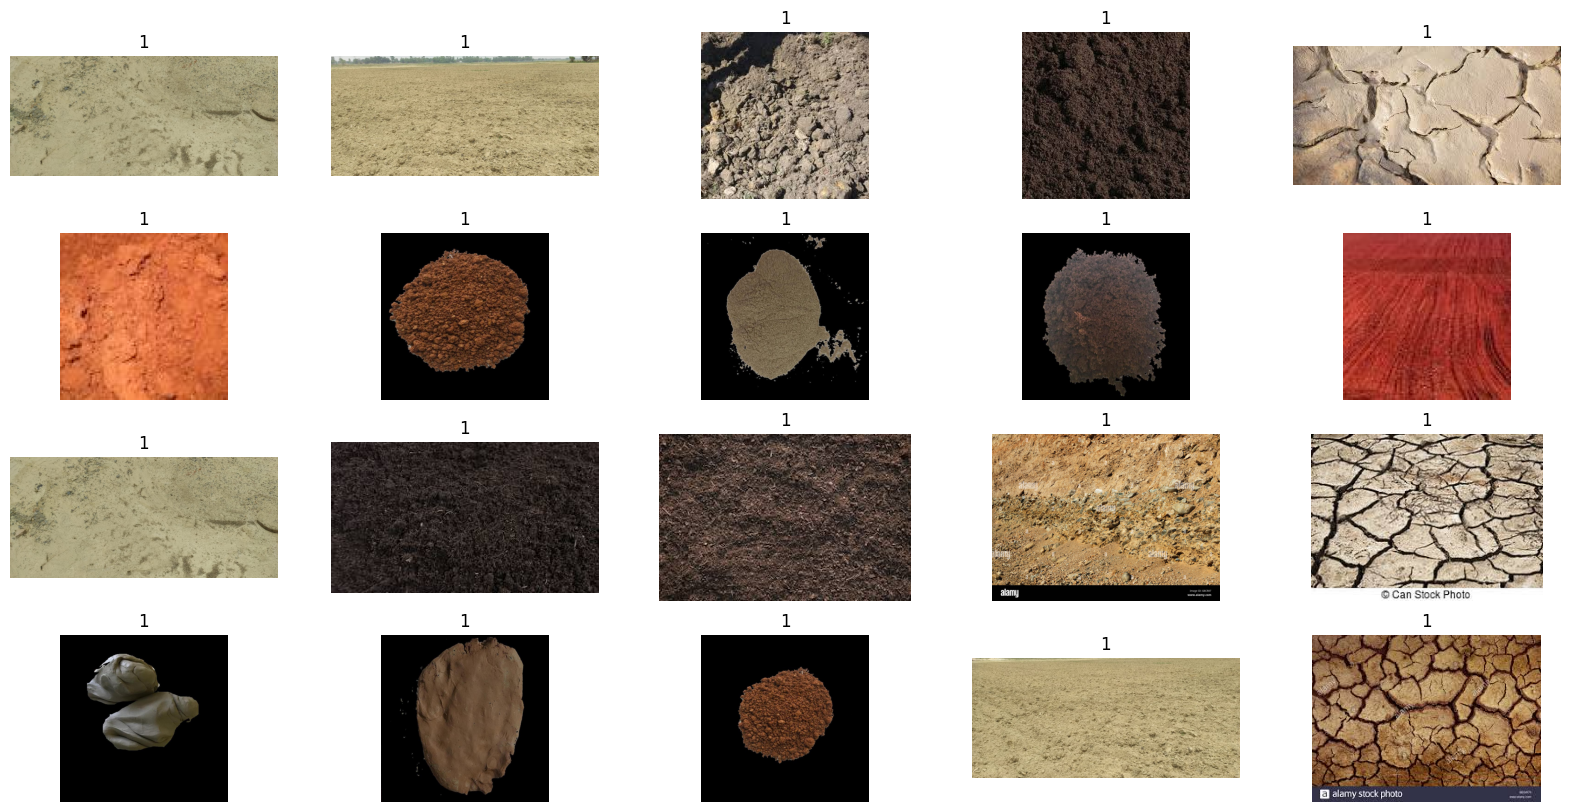

In [44]:
# Function to visualize random images from the dataset
def visualize_data(data, num_images=20, seed=42):
    # Set a random seed for reproducibility
    np.random.seed(seed)

    # Randomly choose indices from the dataset
    idxs = np.random.choice(len(data), size=num_images, replace=False)

    # Set the figure size for plotting
    plt.figure(figsize=(20, 10))

    # Loop over selected indices and plot each image with its label
    for i, idx in enumerate(idxs):
        plt.subplot(4, 5, i + 1)  # 4 rows and 5 columns
        plt.imshow(data['image_data'].iloc[idx])  # Show image

        # Get the label index and convert it back to the label name
        label_idx = data['label'].iloc[idx]
        label_name = [k for k, v in label_mapping.items()
                      if v == label_idx][0]

        plt.title(label_name)  # Set the title as label
        plt.axis('off')  # Hide axes

    # Display the full plot
    plt.show()


# Call the function to visualize 20 random training images
visualize_data(train_data, num_images=20)

In [45]:
# print train and test data shapes
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1222, 3)
Test data shape: (967, 2)


### SOIL DataSet Class


In [46]:
# Custom PyTorch Dataset class for soil image classification
class SoilDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            data (DataFrame): DataFrame containing image data and labels.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image from the DataFrame
        image = self.data['image_data'].iloc[idx]

        # Get the label if it exists, else use -1 (for test data)
        if 'label' in self.data.columns:
            label = self.data['label'].iloc[idx]
        else:
            label = -1

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        # Return the image and its label
        return image, label

### Checking for Class Imbalance


1: 1222


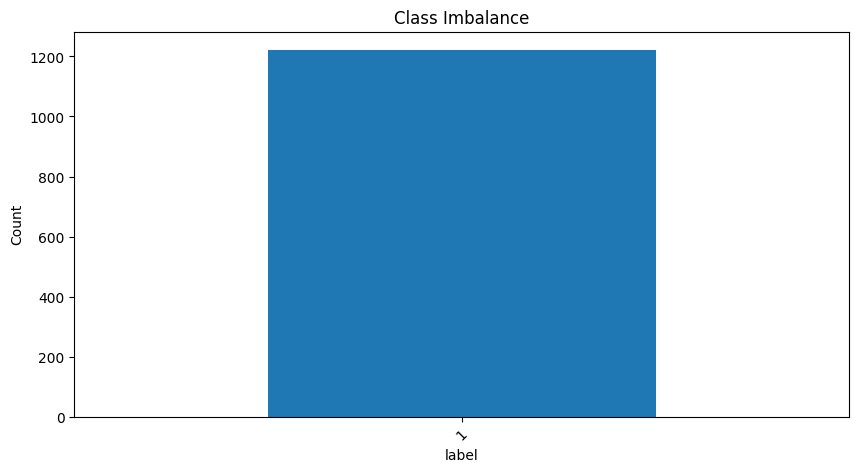

In [47]:
def check_class_imbalance(data):
    # Count the number of samples for each label (by integer label)
    class_counts = data['label'].value_counts().sort_index()

    # Print the count of each class with its original label name
    for idx, count in class_counts.items():
        soil_name = [k for k, v in label_mapping.items() if v == idx][0]
        print(f"{soil_name}: {count}")

    # Plot the class distribution as a bar chart
    plt.figure(figsize=(10, 5))
    class_counts.plot(kind='bar')
    plt.title('Class Imbalance')
    plt.xlabel('label')
    plt.ylabel('Count')

    # Set x-axis labels to only those present in the data
    present_labels = [k for k, v in label_mapping.items()
                      if v in class_counts.index]
    plt.xticks(ticks=range(len(class_counts)),
               labels=present_labels, rotation=45)

    plt.show()


check_class_imbalance(train_data)

Class counts: label
1    1222
Name: count, dtype: int64
1: 1222


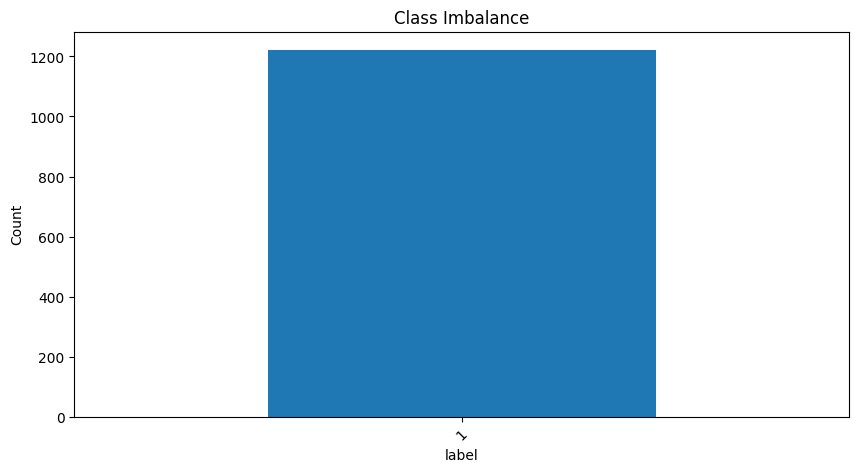

In [48]:
# Function to check and visualize class imbalance in the dataset
def check_class_imbalance(data):
    # Count the number of samples for each label (by integer label)
    class_counts = data['label'].value_counts().sort_index()
    print("Class counts:", class_counts)

    # Print the count of each class with its original label name
    for idx, count in class_counts.items():
        soil_name = [k for k, v in label_mapping.items() if v == idx][0]
        print(f"{soil_name}: {count}")

    # Plot the class distribution as a bar chart
    plt.figure(figsize=(10, 5))
    class_counts.plot(kind='bar')
    plt.title('Class Imbalance')
    plt.xlabel('label')
    plt.ylabel('Count')

    # Set x-axis labels to actual label names
    present_labels = [k for k, v in label_mapping.items()
                      if v in class_counts.index]
    plt.xticks(ticks=range(len(class_counts)),
               labels=present_labels, rotation=45)

    # Show the plot
    plt.show()


# Call the function to visualize class imbalance in the training data
check_class_imbalance(train_data)

### Oversample minority classes to fix class imbalance


In [49]:
# # Seperate by class
# dfs = []
# for class_idx in range(len(label_mapping)):
#     class_df = train_data[train_data['label'] == class_idx]
#     dfs.append(class_df)

# # Find the maximum class size
# max_size = max([len(df) for df in dfs])

# # Resample each class to the max size
# dfs_balanced = [
#     resample(df, replace=True, n_samples=max_size, random_state=42)
#     for df in dfs
# ]

# # Concatenate back into a single DataFrame
# train_data_balanced = pd.concat(dfs_balanced).reset_index(drop=True)

# # Shuffle the balanced dataset
# train_data = train_data_balanced.sample(
#     frac=1, random_state=42).reset_index(drop=True)

# # Check new class distribution
# check_class_imbalance(train_data)

### Data Augmentation Pipeline and Dataloaders


In [50]:
# Define a set of transformations to apply to the images
transform = transforms.Compose([
    # Resize shorter side of image to 256 pixels
    transforms.Resize(256),
    # Random crop to 224x224 with scale variation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    # Randomly flip images horizontally
    transforms.RandomHorizontalFlip(),
    # Randomly change brightness, contrast, saturation, hue
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    # Convert PIL image to PyTorch tensor
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],     # Normalize tensor with ImageNet mean and std
                         std=[0.229, 0.224, 0.225])
])
# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split the training data into training and validation sets with stratification by label
train_split, val_split = train_test_split(
    train_data, test_size=0.3, stratify=train_data['label'], random_state=42)

# Create PyTorch Dataset and DataLoader for training data
train_dataset = SoilDataset(train_split, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create Dataset and DataLoader for validation data (no shuffle to keep order)
val_dataset = SoilDataset(val_split, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Create Dataset and DataLoader for test data (no shuffle)
test_dataset = SoilDataset(test_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Resnet Model


In [51]:
class ResNet18FeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNet18FeatureExtractor, self).__init__()
        resnet = resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-2])  # Exclude avgpool & fc
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Optional, depends on use-case

    def forward(self, x):
        x = self.features(x)           # Output shape: [B, 512, H/32, W/32]
        pooled = self.pool(x)          # Shape: [B, 512, 1, 1]
        return x, pooled.squeeze(-1).squeeze(-1)  # Return both raw and pooled features

model = ResNet18FeatureExtractor().to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training Loop


In [55]:
def calculate_metrics(model, loader):
    model.eval()  # Set model to evaluation mode
    preds, targets = [], []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            features, outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get class predictions
            preds.extend(predicted.cpu().numpy())  # Collect predictions
            targets.extend(labels.cpu().numpy())   # Collect true labels

    # Calculate precision, recall, f1-score (macro average) and accuracy
    precision, recall, f1, _ = precision_recall_fscore_support(
        targets, preds, average='macro')
    acc = accuracy_score(targets, preds)
    return acc, precision, recall, f1


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10):
    # Create directory to save model checkpoints with timestamp
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    output_dir = os.path.join("checkpoints", timestamp)
    os.makedirs(output_dir, exist_ok=True)

    # Track best validation loss to save best model
    best_val_loss = float('inf')
    # Track best training loss if no validation data
    best_train_loss = float('inf')
    all_metrics = []               # Store metrics for each epoch

    for epoch in range(num_epochs):
        model.train()              # Set model to training mode
        running_loss = 0.0
        train_preds, train_targets = [], []

        # Training loop over batches
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()   # Clear previous gradients
            features, outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()         # Backpropagation
            optimizer.step()        # Update model weights

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        # Optionally update learning rate scheduler (commented out here)
        # if scheduler:
        #     scheduler.step()

        # Calculate training metrics for the epoch
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            train_targets, train_preds, average='macro', zero_division=0)
        train_acc = accuracy_score(train_targets, train_preds)
        train_loss = running_loss / len(train_loader)

        metrics = {
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'train_precision': train_precision,
            'train_recall': train_recall,
            'train_f1': train_f1,
        }

        if val_loader is not None:
            # Validation phase
            val_loss = 0.0
            model.eval()  # Set to evaluation mode
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    features, outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            val_acc, val_precision, val_recall, val_f1 = calculate_metrics(
                model, val_loader)

            # Print training and validation results
            print(f"\nEpoch [{epoch+1}/{num_epochs}]")
            print(
                f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}")
            print(
                f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

            # Save best model checkpoint based on validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_path = os.path.join(output_dir, "best_model.pth")
                torch.save(model.state_dict(), best_model_path)
                print(
                    f"✅ Best model saved at epoch {epoch+1} with val loss {best_val_loss:.4f}")

            # Add validation metrics to the metrics dictionary
            metrics.update({
                'val_loss': val_loss,
                'val_accuracy': val_acc,
                'val_precision': val_precision,
                'val_recall': val_recall,
                'val_f1': val_f1,
            })
        else:
            # If no validation loader, only print training results
            print(f"\nEpoch [{epoch+1}/{num_epochs}]")
            print(
                f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}")

            # Save best model based on training loss
            if train_loss < best_train_loss:
                best_train_loss = train_loss
                best_model_path = os.path.join(output_dir, "best_model.pth")
                torch.save(model.state_dict(), best_model_path)
                print(
                    f"✅ Best model saved at epoch {epoch+1} with train loss {best_train_loss:.4f}")

        # Save model at every epoch (can be used for checkpointing)
        torch.save(model.state_dict(), os.path.join(output_dir, "model.pth"))

        # Append metrics of current epoch to list
        all_metrics.append(metrics)

    # Save all metrics collected over epochs to a CSV file
    df_metrics = pd.DataFrame(all_metrics)
    metrics_path = os.path.join(output_dir, "training_metrics.csv")
    df_metrics.to_csv(metrics_path, index=False)
    print(f"📊 Metrics saved to {metrics_path}")

In [56]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [57]:
# Train the model for n epochs
train_model(model, train_loader, val_loader,
            criterion, optimizer, num_epochs=30)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [1/30]
Train Loss: 5.1720 | Train Acc: 0.6058 | Train F1: 0.0269
Val Loss: 6.1853 | Val Acc: 0.5995 | Val F1: 0.0681
✅ Best model saved at epoch 1 with val loss 6.1853


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [2/30]
Train Loss: 4.9721 | Train Acc: 0.6129 | Train F1: 0.0691
Val Loss: 4.8567 | Val Acc: 0.7738 | Val F1: 0.0969
✅ Best model saved at epoch 2 with val loss 4.8567


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [3/30]
Train Loss: 4.8708 | Train Acc: 0.6421 | Train F1: 0.0559
Val Loss: 5.4615 | Val Acc: 0.5695 | Val F1: 0.1209


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [4/30]
Train Loss: 4.7529 | Train Acc: 0.6363 | Train F1: 0.0598
Val Loss: 4.6226 | Val Acc: 0.6676 | Val F1: 0.2002
✅ Best model saved at epoch 4 with val loss 4.6226


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [5/30]
Train Loss: 4.6396 | Train Acc: 0.6667 | Train F1: 0.0667
Val Loss: 4.2313 | Val Acc: 0.8202 | Val F1: 0.1802
✅ Best model saved at epoch 5 with val loss 4.2313


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [6/30]
Train Loss: 4.5285 | Train Acc: 0.6889 | Train F1: 0.0816
Val Loss: 4.6593 | Val Acc: 0.6594 | Val F1: 0.1987


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [7/30]
Train Loss: 4.4236 | Train Acc: 0.6702 | Train F1: 0.1338
Val Loss: 4.6500 | Val Acc: 0.6757 | Val F1: 0.1152


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [8/30]
Train Loss: 4.3122 | Train Acc: 0.7170 | Train F1: 0.1044
Val Loss: 4.3703 | Val Acc: 0.6975 | Val F1: 0.2739


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [9/30]
Train Loss: 4.2361 | Train Acc: 0.7251 | Train F1: 0.0701
Val Loss: 4.1231 | Val Acc: 0.7139 | Val F1: 0.2777
✅ Best model saved at epoch 9 with val loss 4.1231


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [10/30]
Train Loss: 4.1687 | Train Acc: 0.7439 | Train F1: 0.1219
Val Loss: 4.2661 | Val Acc: 0.8011 | Val F1: 0.1271


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [11/30]
Train Loss: 4.0375 | Train Acc: 0.7532 | Train F1: 0.0781
Val Loss: 4.0155 | Val Acc: 0.7057 | Val F1: 0.2069
✅ Best model saved at epoch 11 with val loss 4.0155


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [12/30]
Train Loss: 3.9212 | Train Acc: 0.7509 | Train F1: 0.1072
Val Loss: 4.1533 | Val Acc: 0.6703 | Val F1: 0.2675


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [13/30]
Train Loss: 3.8269 | Train Acc: 0.7520 | Train F1: 0.2146
Val Loss: 4.1347 | Val Acc: 0.7057 | Val F1: 0.2069


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [14/30]
Train Loss: 3.7296 | Train Acc: 0.7673 | Train F1: 0.1240
Val Loss: 3.8026 | Val Acc: 0.7384 | Val F1: 0.4248
✅ Best model saved at epoch 14 with val loss 3.8026


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [15/30]
Train Loss: 3.6501 | Train Acc: 0.7965 | Train F1: 0.1478
Val Loss: 3.8075 | Val Acc: 0.7439 | Val F1: 0.2844


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [16/30]
Train Loss: 3.5408 | Train Acc: 0.7591 | Train F1: 0.1438
Val Loss: 3.6158 | Val Acc: 0.7575 | Val F1: 0.4310
✅ Best model saved at epoch 16 with val loss 3.6158


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [17/30]
Train Loss: 3.4410 | Train Acc: 0.7918 | Train F1: 0.1105
Val Loss: 3.3174 | Val Acc: 0.7902 | Val F1: 0.4414
✅ Best model saved at epoch 17 with val loss 3.3174


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [18/30]
Train Loss: 3.3496 | Train Acc: 0.7988 | Train F1: 0.2961
Val Loss: 3.6535 | Val Acc: 0.7221 | Val F1: 0.4193


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [19/30]
Train Loss: 3.2555 | Train Acc: 0.8433 | Train F1: 0.2287
Val Loss: 3.3740 | Val Acc: 0.8011 | Val F1: 0.2965


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [20/30]
Train Loss: 3.1698 | Train Acc: 0.8596 | Train F1: 0.0925
Val Loss: 3.5262 | Val Acc: 0.7820 | Val F1: 0.4388


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [21/30]
Train Loss: 3.0789 | Train Acc: 0.8924 | Train F1: 0.1048
Val Loss: 2.7771 | Val Acc: 0.9510 | Val F1: 0.3250
✅ Best model saved at epoch 21 with val loss 2.7771


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [22/30]
Train Loss: 2.9945 | Train Acc: 0.9064 | Train F1: 0.0731
Val Loss: 3.0556 | Val Acc: 0.8583 | Val F1: 0.2309


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [23/30]
Train Loss: 2.9030 | Train Acc: 0.9135 | Train F1: 0.0734
Val Loss: 2.4450 | Val Acc: 0.9646 | Val F1: 0.2455
✅ Best model saved at epoch 23 with val loss 2.4450


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [24/30]
Train Loss: 2.8205 | Train Acc: 0.9018 | Train F1: 0.0790
Val Loss: 2.7642 | Val Acc: 0.8719 | Val F1: 0.1863


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [25/30]
Train Loss: 2.7364 | Train Acc: 0.8643 | Train F1: 0.0464
Val Loss: 2.5138 | Val Acc: 0.9292 | Val F1: 0.3211


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch [26/30]
Train Loss: 2.6556 | Train Acc: 0.9158 | Train F1: 0.0869
Val Loss: 2.6037 | Val Acc: 0.9619 | Val F1: 0.3269

Epoch [27/30]
Train Loss: 2.5718 | Train Acc: 0.9918 | Train F1: 0.1660
Val Loss: 1.8209 | Val Acc: 1.0000 | Val F1: 1.0000
✅ Best model saved at epoch 27 with val loss 1.8209

Epoch [28/30]
Train Loss: 2.4765 | Train Acc: 1.0000 | Train F1: 1.0000
Val Loss: 2.3653 | Val Acc: 1.0000 | Val F1: 1.0000

Epoch [29/30]
Train Loss: 2.3780 | Train Acc: 1.0000 | Train F1: 1.0000
Val Loss: 2.7849 | Val Acc: 1.0000 | Val F1: 1.0000

Epoch [30/30]
Train Loss: 2.2930 | Train Acc: 1.0000 | Train F1: 1.0000
Val Loss: 2.4012 | Val Acc: 1.0000 | Val F1: 1.0000
📊 Metrics saved to checkpoints/2025-05-24_17-00-43/training_metrics.csv


In [58]:
from sklearn.svm import OneClassSVM

def extract_features(model, loader):
    model.eval()
    features_list = []
    labels_list = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            feats, _ = model(images)
            feats = feats.view(feats.size(0), -1).cpu().numpy()
            features_list.append(feats)
            labels_list.append(labels.cpu().numpy())
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return features, labels

# Extract features for train, val, and test sets
train_features, train_labels = extract_features(model, train_loader)
val_features, val_labels = extract_features(model, val_loader)
test_features, _ = extract_features(model, test_loader)

# Fit One-Class SVM on training features (assuming class 1 is "normal")
svm = OneClassSVM(gamma='auto').fit(train_features[train_labels == 1])

# Predict on train, val, and test sets
train_pred = svm.predict(train_features)
val_pred = svm.predict(val_features)
test_pred = svm.predict(test_features)

# Map SVM output (-1, 1) to (0, 1)
train_pred = (train_pred == 1).astype(int)
val_pred = (val_pred == 1).astype(int)
test_pred = (test_pred == 1).astype(int)

# Print accuracy for train and val
print("Train SVM accuracy:", np.mean(train_pred == train_labels))
print("Val SVM accuracy:", np.mean(val_pred == val_labels))

# test_pred contains the predicted class (0 or 1) for the test set

Train SVM accuracy: 0.5005847953216375
Val SVM accuracy: 0.5422343324250681


### Visualizing Predictions on Training Set


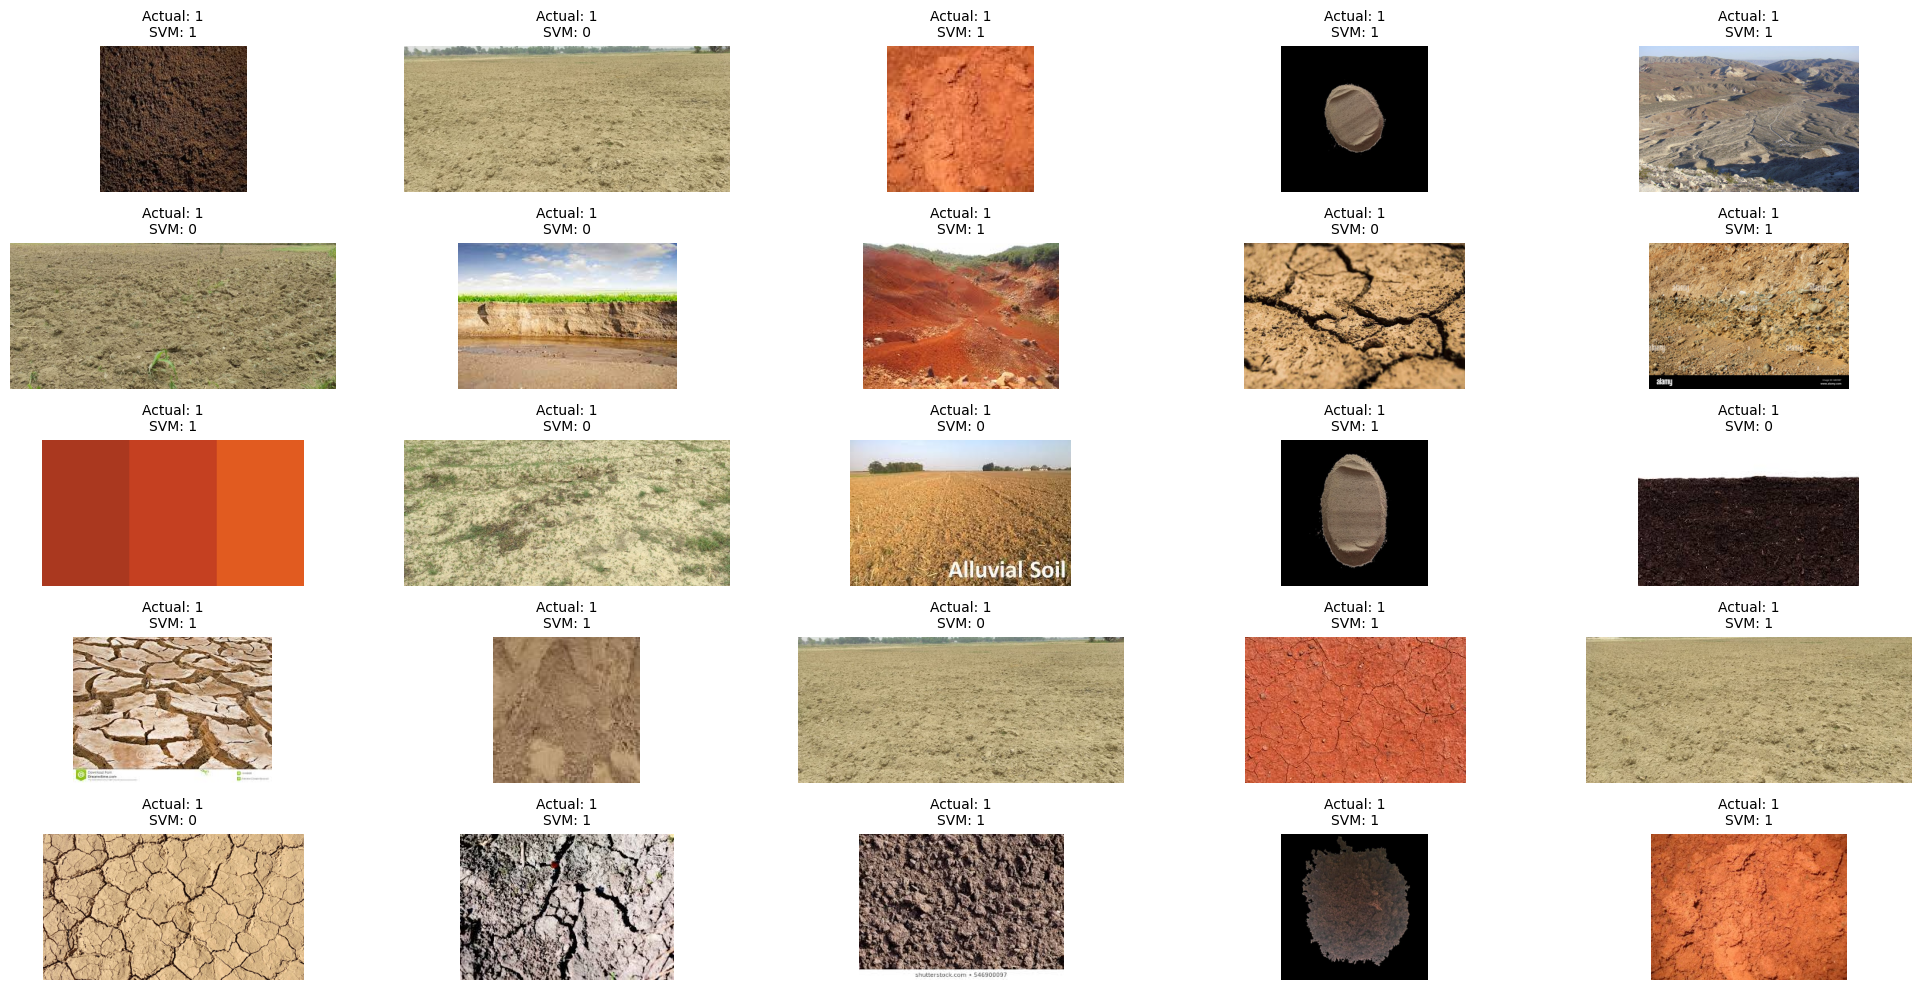

In [59]:
# Visualize predictions using the One-Class SVM on the training dataset

def visualize_ocsvm_predictions(svm, loader, num_images=20, seed=42):
    np.random.seed(seed)
    idxs = np.random.choice(len(loader.dataset), size=num_images, replace=False)

    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(idxs):
        # Extract features for the selected image
        image, actual_label = loader.dataset[idx]
        image_input = image.unsqueeze(0).to(device)
        with torch.no_grad():
            feats, _ = model(image_input)
            feats = feats.view(feats.size(0), -1).cpu().numpy()

        # SVM prediction
        pred = svm.predict(feats)[0]
        pred_label = int(pred == 1)  # SVM: 1 (inlier), -1 (outlier)

        # Plot the original PIL image
        plt.subplot(5, 5, i + 1)
        pil_img = loader.dataset.data['image_data'].iloc[idx]
        plt.imshow(pil_img)

        # Map label indices to names
        actual_name = [k for k, v in label_mapping.items() if v == actual_label][0]
        predicted_name = [k for k, v in label_mapping.items() if v == pred_label][0]

        plt.title(f"Actual: {actual_name}\nSVM: {predicted_name}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize SVM predictions on 25 random images from the training dataset
visualize_ocsvm_predictions(svm, train_loader, num_images=25)

### Visualizing Predictions on Validation Set


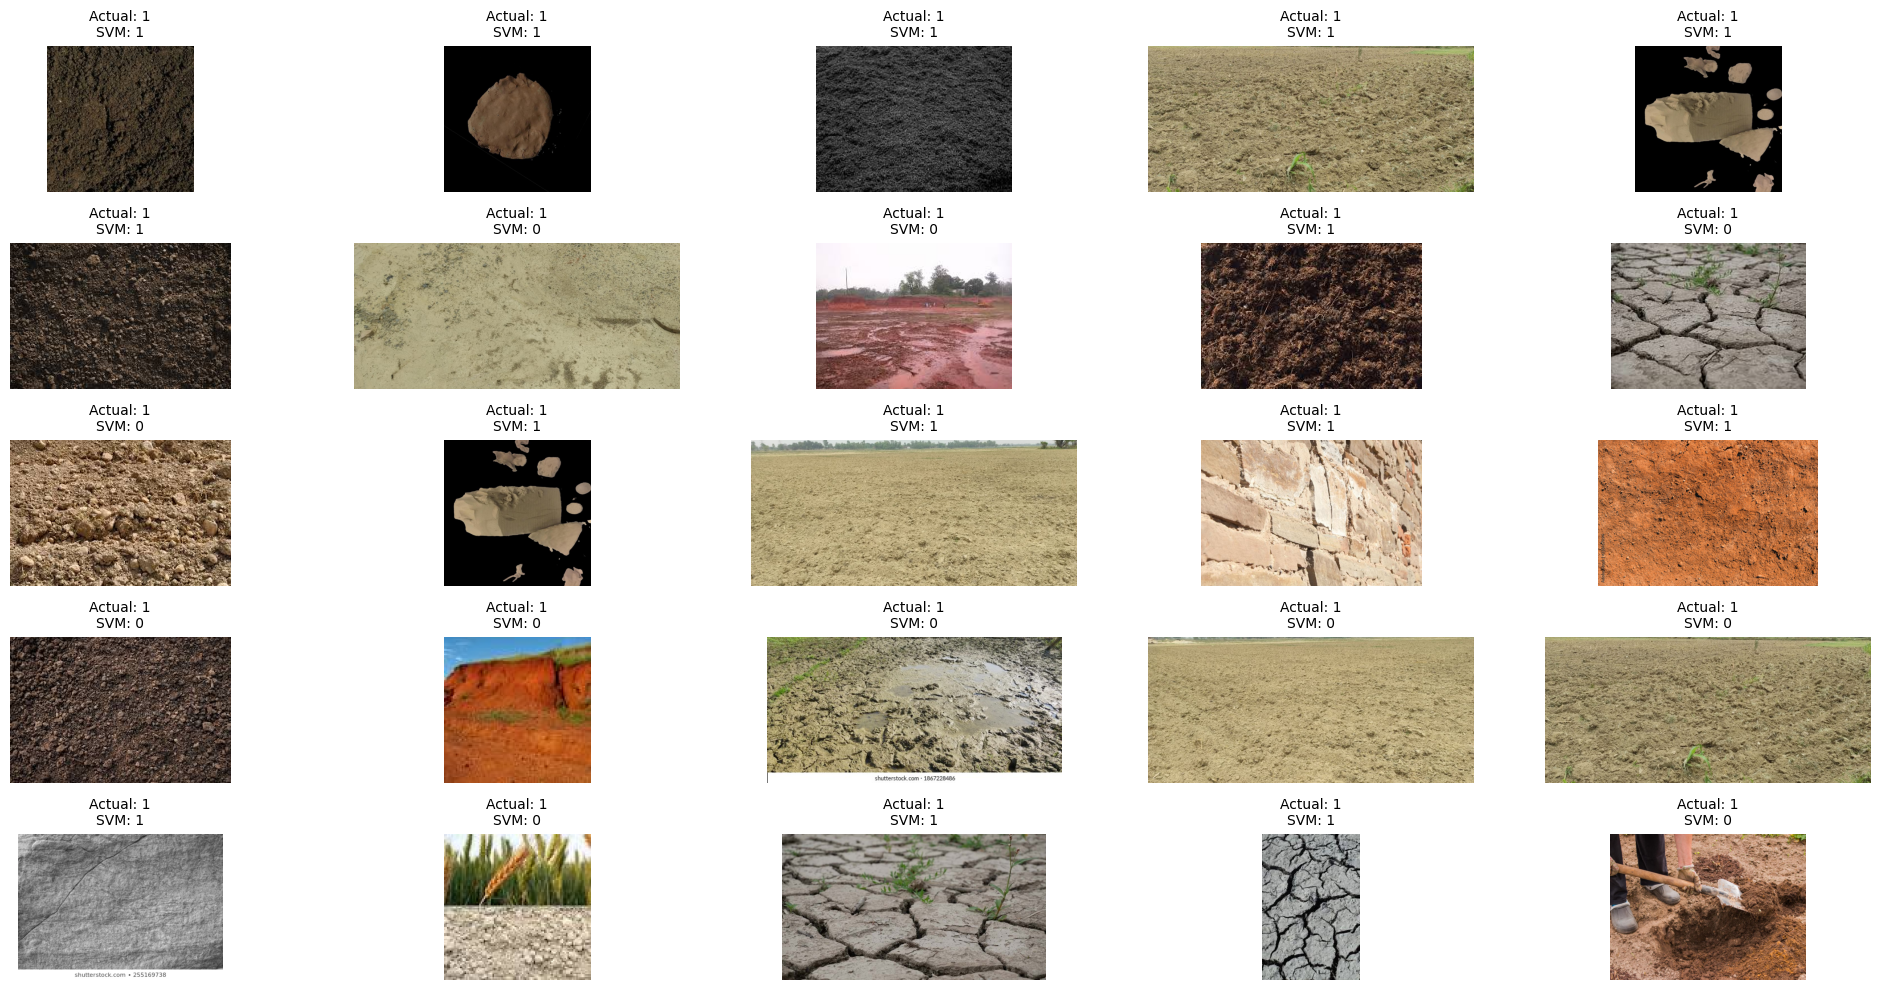

In [60]:
# Visualize predictions using the One-Class SVM on the training dataset

def visualize_ocsvm_predictions(svm, loader, num_images=20, seed=42):
    np.random.seed(seed)
    idxs = np.random.choice(len(loader.dataset), size=num_images, replace=False)

    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(idxs):
        # Extract features for the selected image
        image, actual_label = loader.dataset[idx]
        image_input = image.unsqueeze(0).to(device)
        with torch.no_grad():
            feats, _ = model(image_input)
            feats = feats.view(feats.size(0), -1).cpu().numpy()

        # SVM prediction
        pred = svm.predict(feats)[0]
        pred_label = int(pred == 1)  # SVM: 1 (inlier), -1 (outlier)

        # Plot the original PIL image
        plt.subplot(5, 5, i + 1)
        pil_img = loader.dataset.data['image_data'].iloc[idx]
        plt.imshow(pil_img)

        # Map label indices to names
        actual_name = [k for k, v in label_mapping.items() if v == actual_label][0]
        predicted_name = [k for k, v in label_mapping.items() if v == pred_label][0]

        plt.title(f"Actual: {actual_name}\nSVM: {predicted_name}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize SVM predictions on 25 random images from the training dataset
visualize_ocsvm_predictions(svm, val_loader, num_images=25)

### VIsualizing Predictions on Test Set


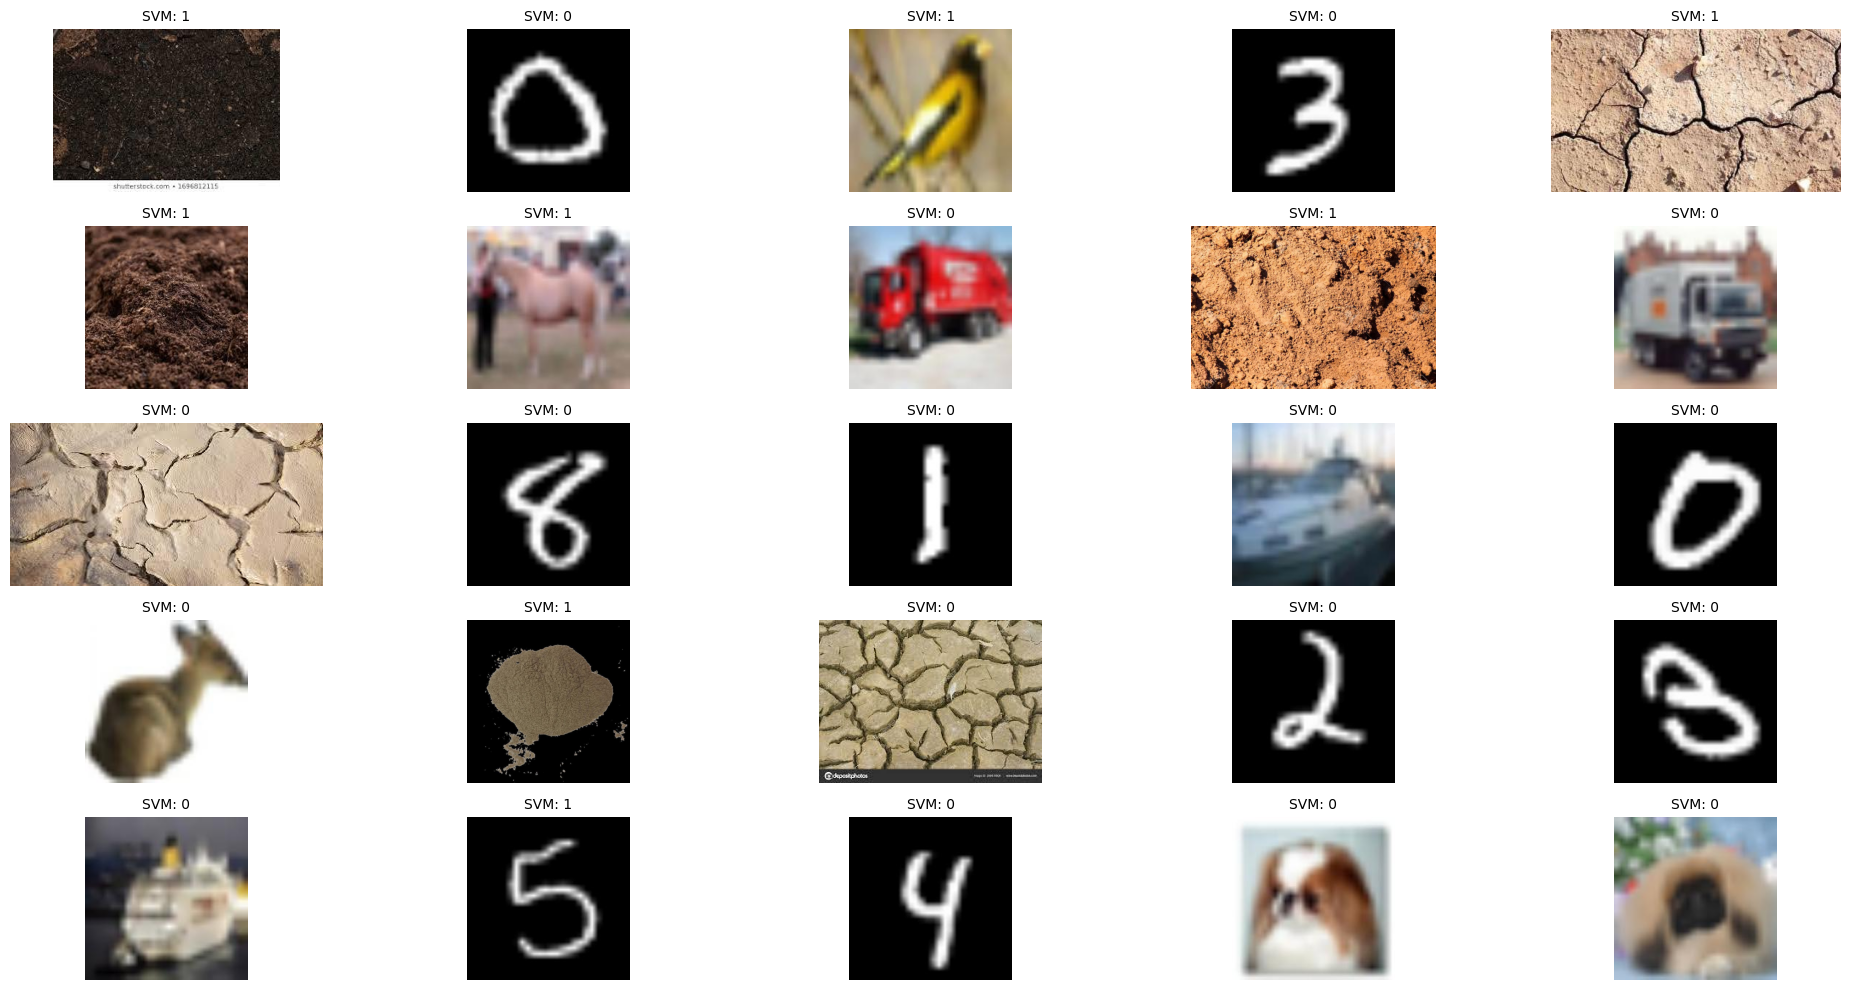

In [61]:
# Visualize predictions using the One-Class SVM on the training dataset

def visualize_ocsvm_predictions(svm, loader, num_images=20, seed=42):
    np.random.seed(seed)
    idxs = np.random.choice(len(loader.dataset), size=num_images, replace=False)

    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(idxs):
        # Extract features for the selected image
        image, actual_label = loader.dataset[idx]
        image_input = image.unsqueeze(0).to(device)
        with torch.no_grad():
            feats, _ = model(image_input)
            feats = feats.view(feats.size(0), -1).cpu().numpy()

        # SVM prediction
        pred = svm.predict(feats)[0]
        pred_label = int(pred == 1)  # SVM: 1 (inlier), -1 (outlier)

        # Plot the original PIL image
        plt.subplot(5, 5, i + 1)
        pil_img = loader.dataset.data['image_data'].iloc[idx]
        plt.imshow(pil_img)
        predicted_name = [k for k, v in label_mapping.items() if v == pred_label][0]

        plt.title(f"SVM: {predicted_name}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize SVM predictions on 25 random images from the training dataset
visualize_ocsvm_predictions(svm, test_loader, num_images=25)

### Confusion Matrix


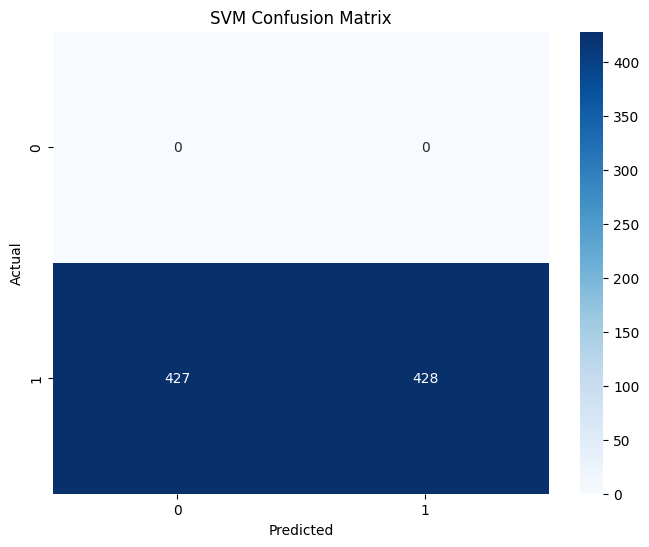

SVM Classification Report:

              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      1.000     0.501     0.667       855

    accuracy                          0.501       855
   macro avg      0.500     0.250     0.334       855
weighted avg      1.000     0.501     0.667       855



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
# Use the trained SVM model to predict on the training set features
train_pred = svm.predict(train_features)
# Map SVM output (-1, 1) to (0, 1)
train_pred = (train_pred == 1).astype(int)

# Compute confusion matrix and classification report using SVM predictions
cm = confusion_matrix(train_labels, train_pred)
class_names = [k for k, v in sorted(label_mapping.items(), key=lambda item: item[1])]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

report = classification_report(train_labels, train_pred, digits=3)
print("SVM Classification Report:\n")
print(report)

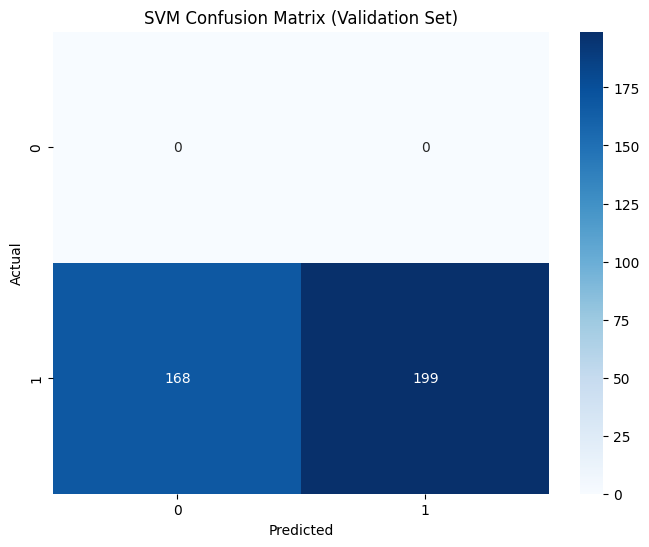

SVM Classification Report (Validation Set):

              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      1.000     0.542     0.703       367

    accuracy                          0.542       367
   macro avg      0.500     0.271     0.352       367
weighted avg      1.000     0.542     0.703       367



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
# Use the trained SVM model to predict on the validation set features
val_pred = svm.predict(val_features)
# Map SVM output (-1, 1) to (0, 1)
val_pred = (val_pred == 1).astype(int)

# Compute confusion matrix and classification report using SVM predictions
cm = confusion_matrix(val_labels, val_pred)
class_names = [k for k, v in sorted(
    label_mapping.items(), key=lambda item: item[1])]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix (Validation Set)')
plt.show()

report = classification_report(val_labels, val_pred, digits=3)
print("SVM Classification Report (Validation Set):\n")
print(report)

### Generate the submission


In [64]:
def generate_submission_svm(svm, model, test_loader, output_path='submission.csv'):
    model.eval()
    preds = []
    image_ids = test_data['image_id'].tolist()

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            feats, _ = model(images)
            feats = feats.view(feats.size(0), -1).cpu().numpy()
            pred = svm.predict(feats)
            pred = (pred == 1).astype(int)
            preds.extend(pred)

    inv_mapping = {v: k for k, v in label_mapping.items()}
    labels = [inv_mapping[p] for p in preds]

    submission = pd.DataFrame({'image_id': image_ids, 'label': labels})
    submission.to_csv(output_path, index=False)

# Generate submission file with SVM predictions on test data
generate_submission_svm(svm, model, test_loader, output_path='submission.csv')